# VISUALIZING WHAT CONVNETS LEARN
## 1. Visualizing intermediate activations

In [0]:
# Loading pretrained model
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [0]:
img_path = 'cats_and_dogs_small_dataset/test/cats/cat.1700.jpg'

In [0]:
# preprocessing a single image
from keras.preprocessing import image                             
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.     

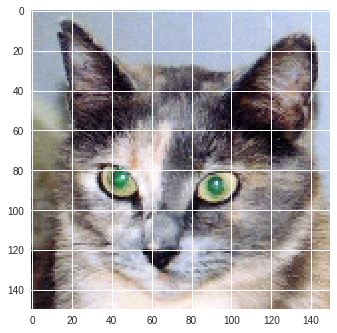

In [7]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [0]:
# Here the output of the model is the activation of the first eight layers
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]               
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [0]:
activations = activation_model.predict(img_tensor)

In [0]:
first_layer_activation = activations[0]

In [14]:
print(first_layer_activation.shape)

(1, 148, 148, 32)


**Fourth channel of the activation of the first layer on the test cat picture**

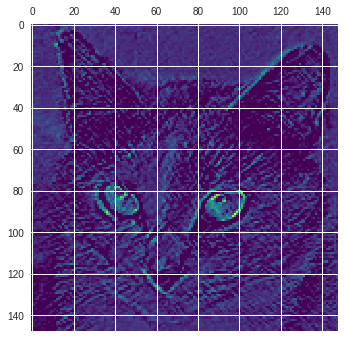

In [15]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

**Seventh channel of the activation of the first layer on the test cat picture**

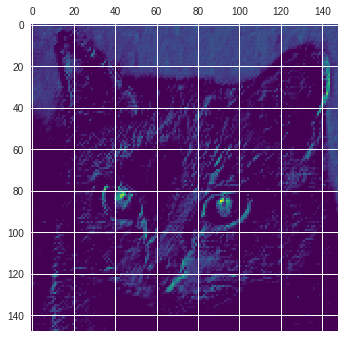

In [16]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

**Every channel of every layer activation on the test cat picture**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


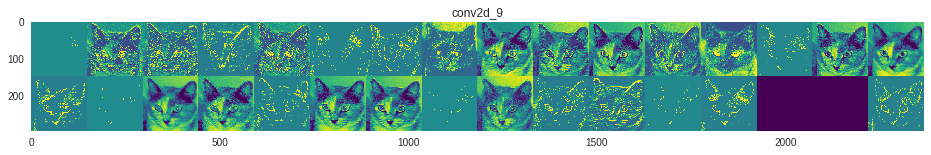

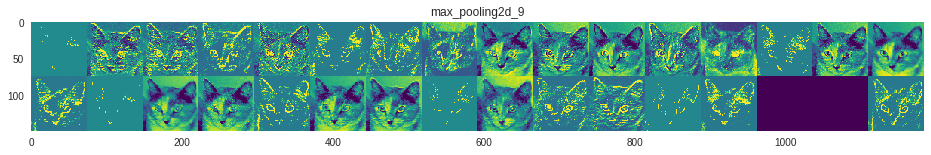

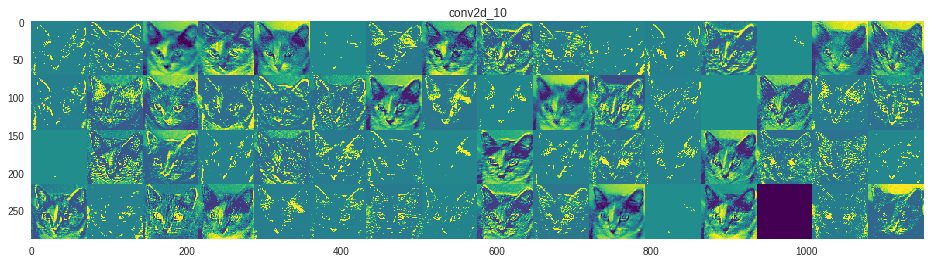

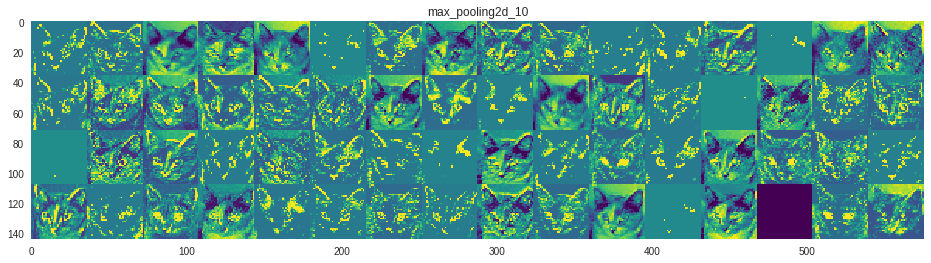

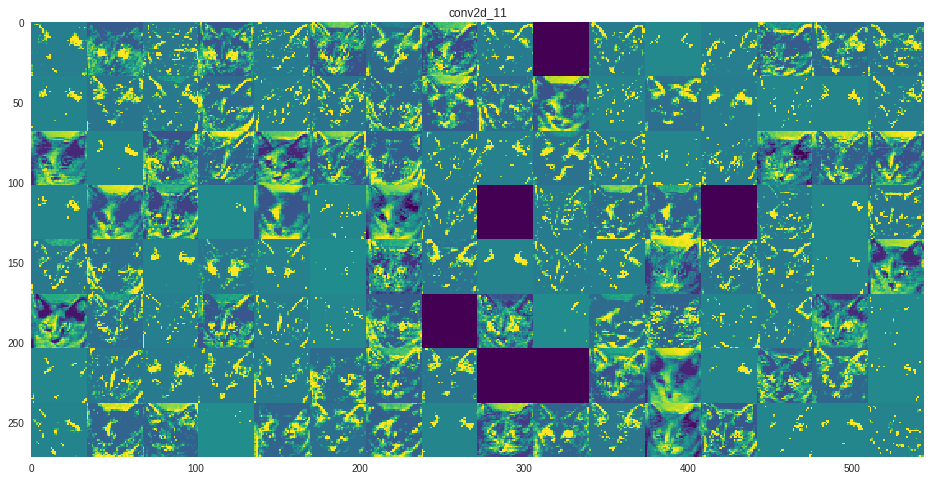

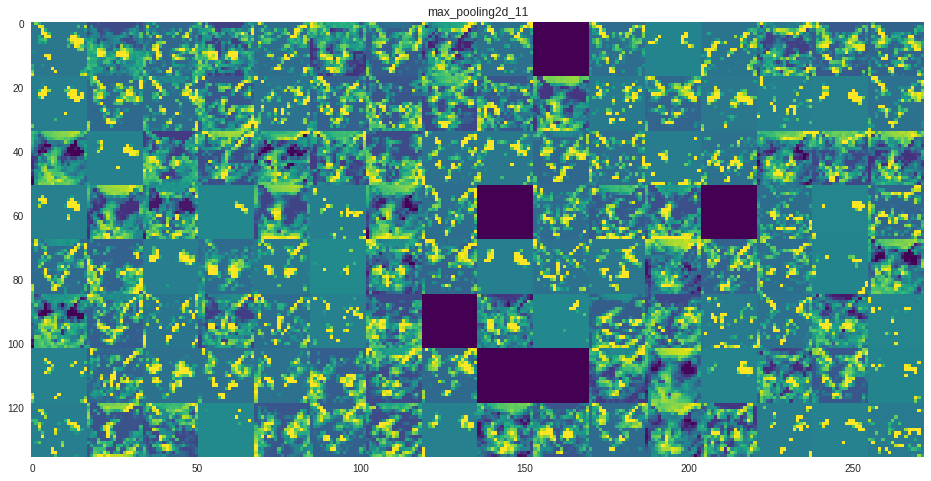

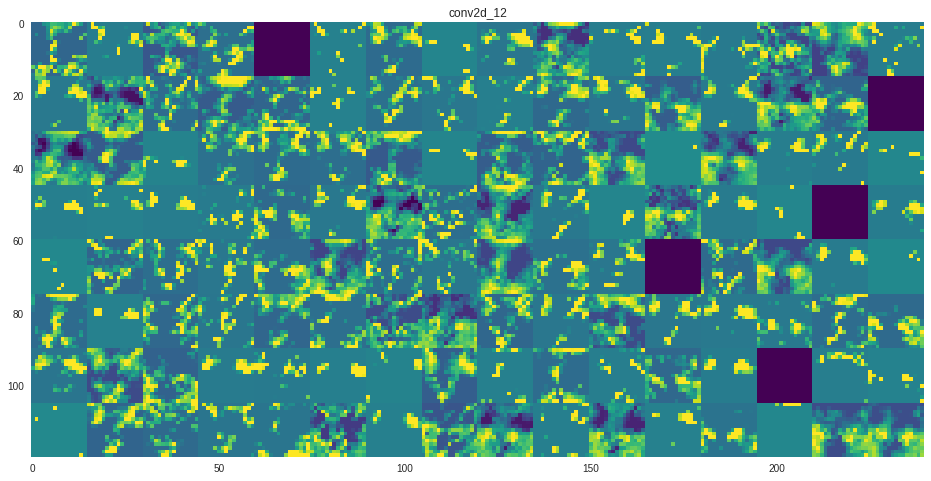

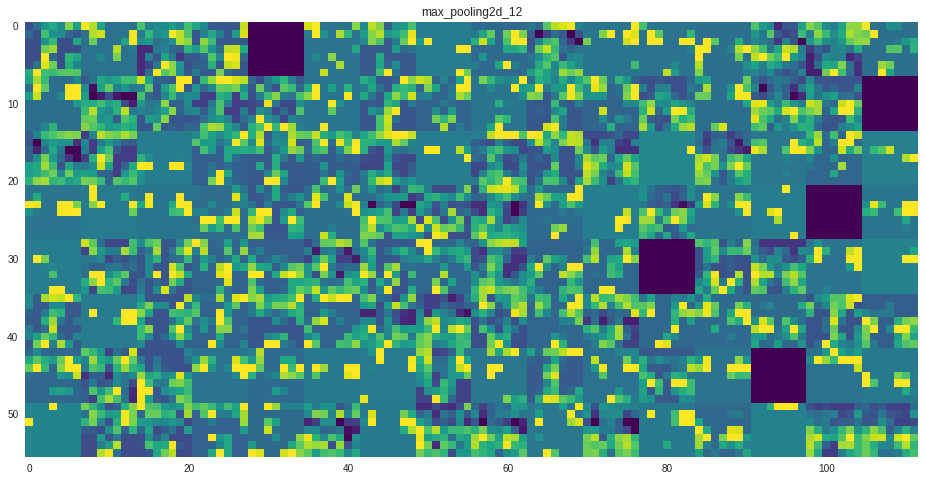

In [17]:
layer_names = []                                                          
for layer in model.layers[:8]:                                            
    layer_names.append(layer.name)                                        

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):        
    n_features = layer_activation.shape[-1]                               

    size = layer_activation.shape[1]                                      

    n_cols = n_features // images_per_row                                 
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):                                             
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            
            # Post-processes the feature to make it visually palatable
            channel_image -= channel_image.mean()                         
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,                   
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Visualizing convnet filters
*This can be done with gradient ascent in input space: applying gradient descent to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input image. The resulting input image will be one that the chosen filter is maximally responsive to.*

In [0]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [0]:
# Utility function to convert a tensor into a valid image
def deprocess_image(x):
    x -= x.mean()                                
    x /= (x.std() + 1e-5)                        
    x *= 0.1                                     

    x += 0.5                                     
    x = np.clip(x, 0, 1)                         

    x *= 255                                     
    x = np.clip(x, 0, 255).astype('uint8')       
    return x 

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output                     
    loss = K.mean(layer_output[:, :, :, filter_index])                    

    grads = K.gradients(loss, model.input)[0]                             
  
    # Gradient-normalization trick
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)                     

    iterate = K.function([model.input], [loss, grads]) 
    
    
    # Starts from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.     
    
    # Loss maximization via stochastic gradient descent
    step = 1.                                                             
    for i in range(40):                                                   
        loss_value, grads_value = iterate([input_img_data])               
        input_img_data += grads_value * step                              

    img = input_img_data[0]
    return deprocess_image(img)

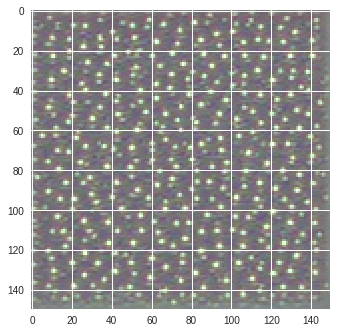

In [28]:
plt.imshow(generate_pattern('block3_conv1', 0))

# **The filters from the first layer in the model (block1_conv1) encode simple directional edges and colors (or colored edges, in some cases).**

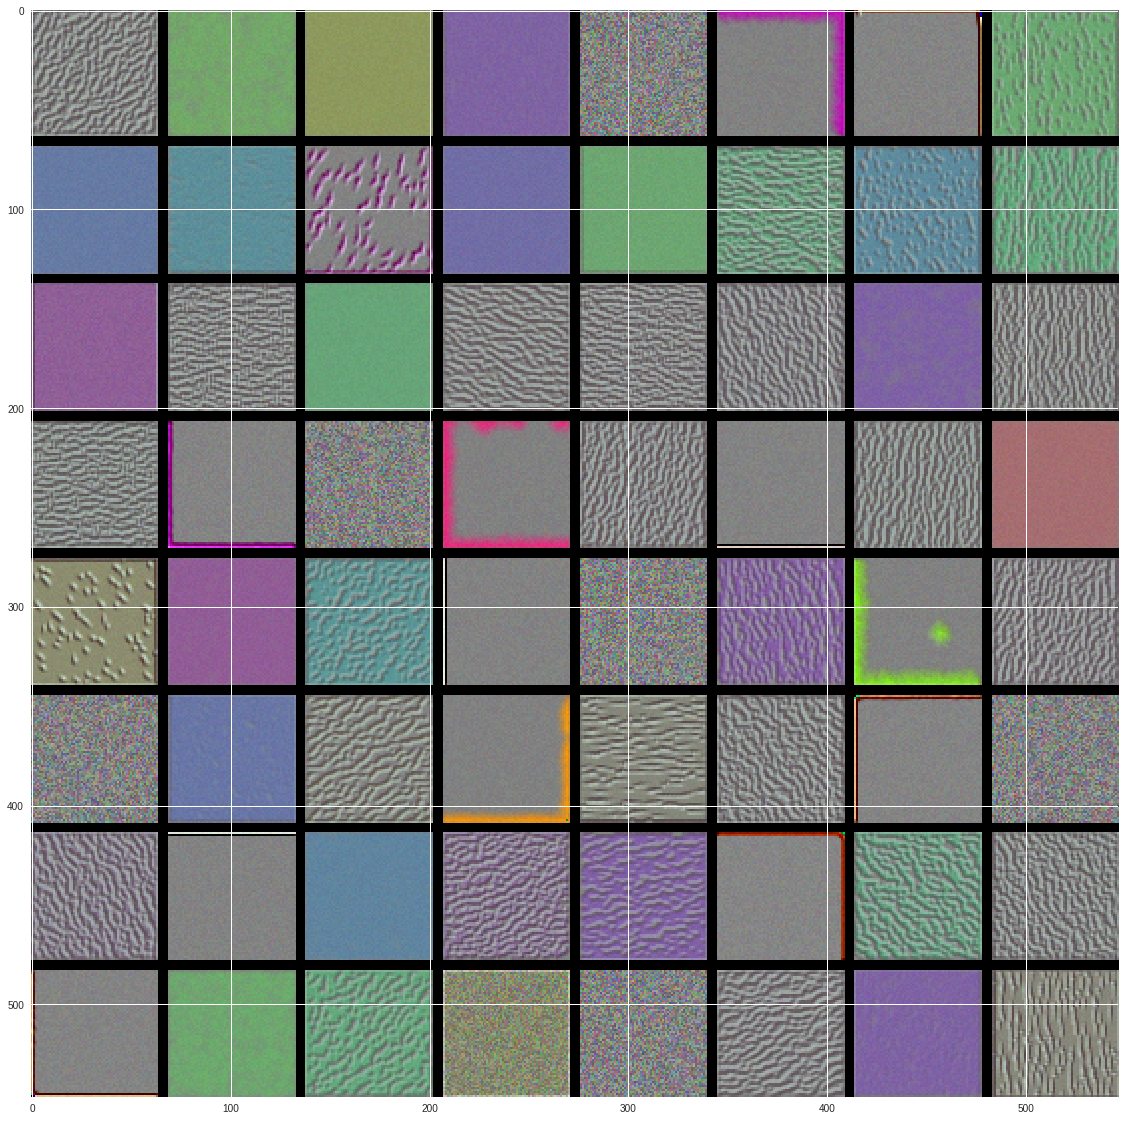

In [29]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))      

for i in range(8):                                                         
    for j in range(8):                                                     
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)  

        horizontal_start = i * size + i * margin                           
        horizontal_end = horizontal_start + size                           
        vertical_start = j * size + j * margin                             
        vertical_end = vertical_start + size                               
        results[horizontal_start: horizontal_end,                          
                vertical_start: vertical_end, :] = filter_img              

plt.figure(figsize=(20, 20))                                               
plt.imshow(results)  

# **The filters from block2_conv1 encode simple textures made from combinations of edges and colors**

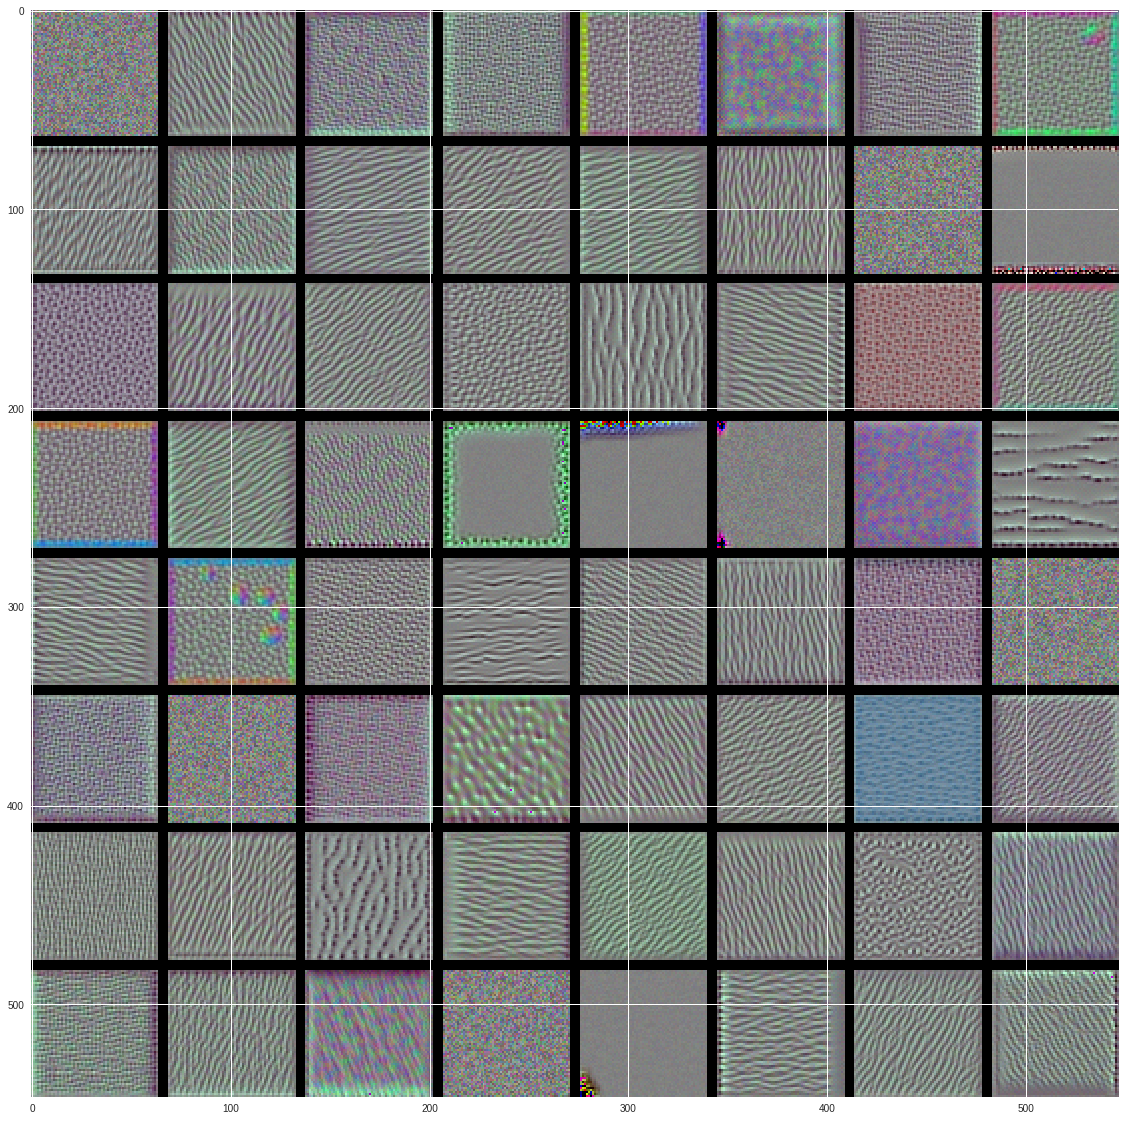

In [31]:
layer_name = 'block2_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))      

for i in range(8):                                                         
    for j in range(8):                                                     
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)  

        horizontal_start = i * size + i * margin                           
        horizontal_end = horizontal_start + size                           
        vertical_start = j * size + j * margin                             
        vertical_end = vertical_start + size                               
        results[horizontal_start: horizontal_end,                          
                vertical_start: vertical_end, :] = filter_img              

plt.figure(figsize=(20, 20))                                               
plt.imshow(results)  

# The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on

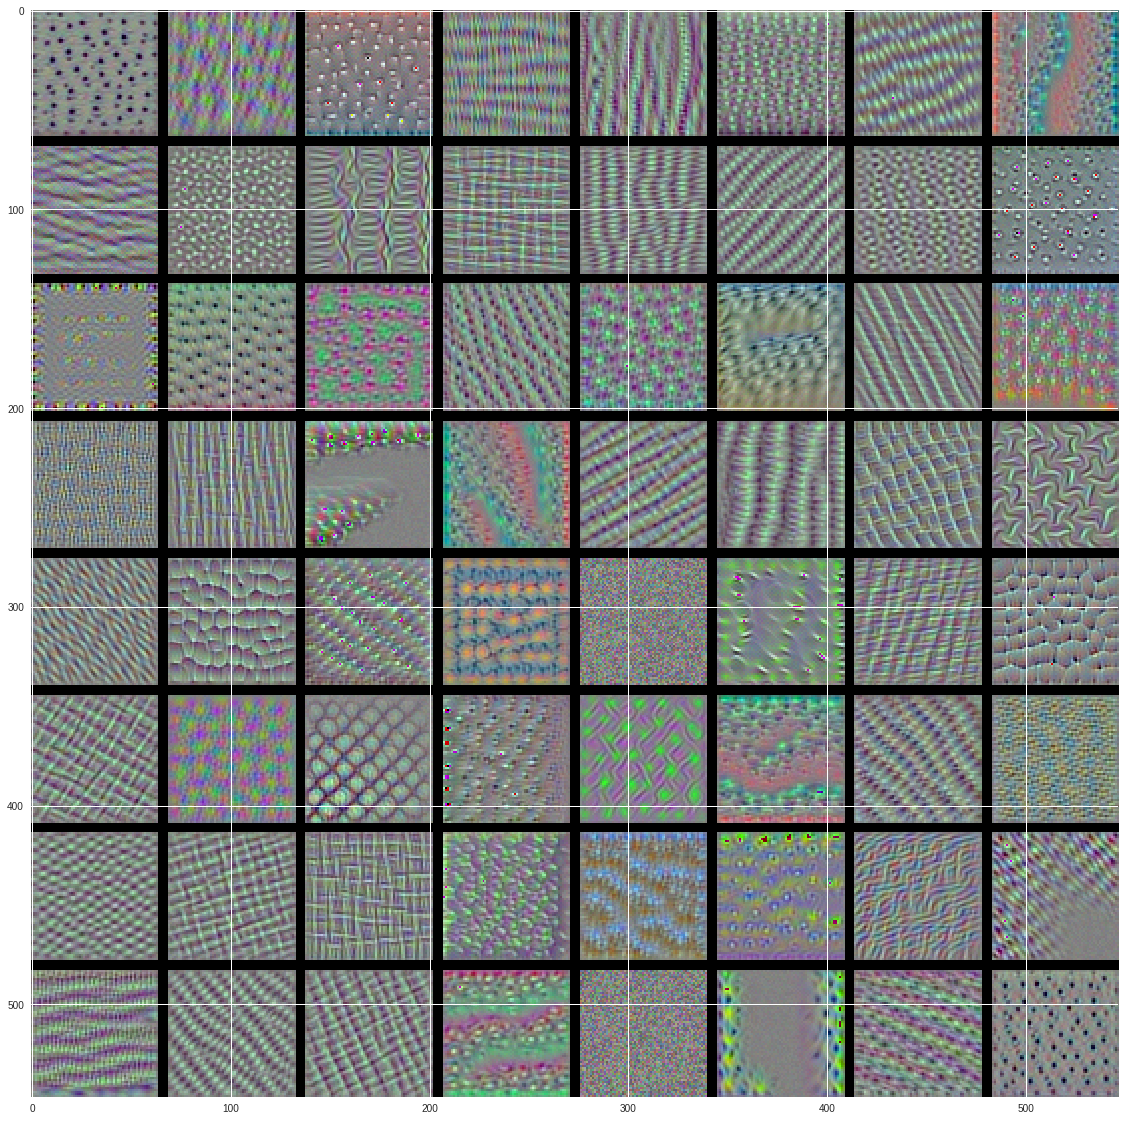

In [32]:
layer_name = 'block3_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))      

for i in range(8):                                                         
    for j in range(8):                                                     
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)  

        horizontal_start = i * size + i * margin                           
        horizontal_end = horizontal_start + size                           
        vertical_start = j * size + j * margin                             
        vertical_end = vertical_start + size                               
        results[horizontal_start: horizontal_end,                          
                vertical_start: vertical_end, :] = filter_img              

plt.figure(figsize=(20, 20))                                               
plt.imshow(results)  

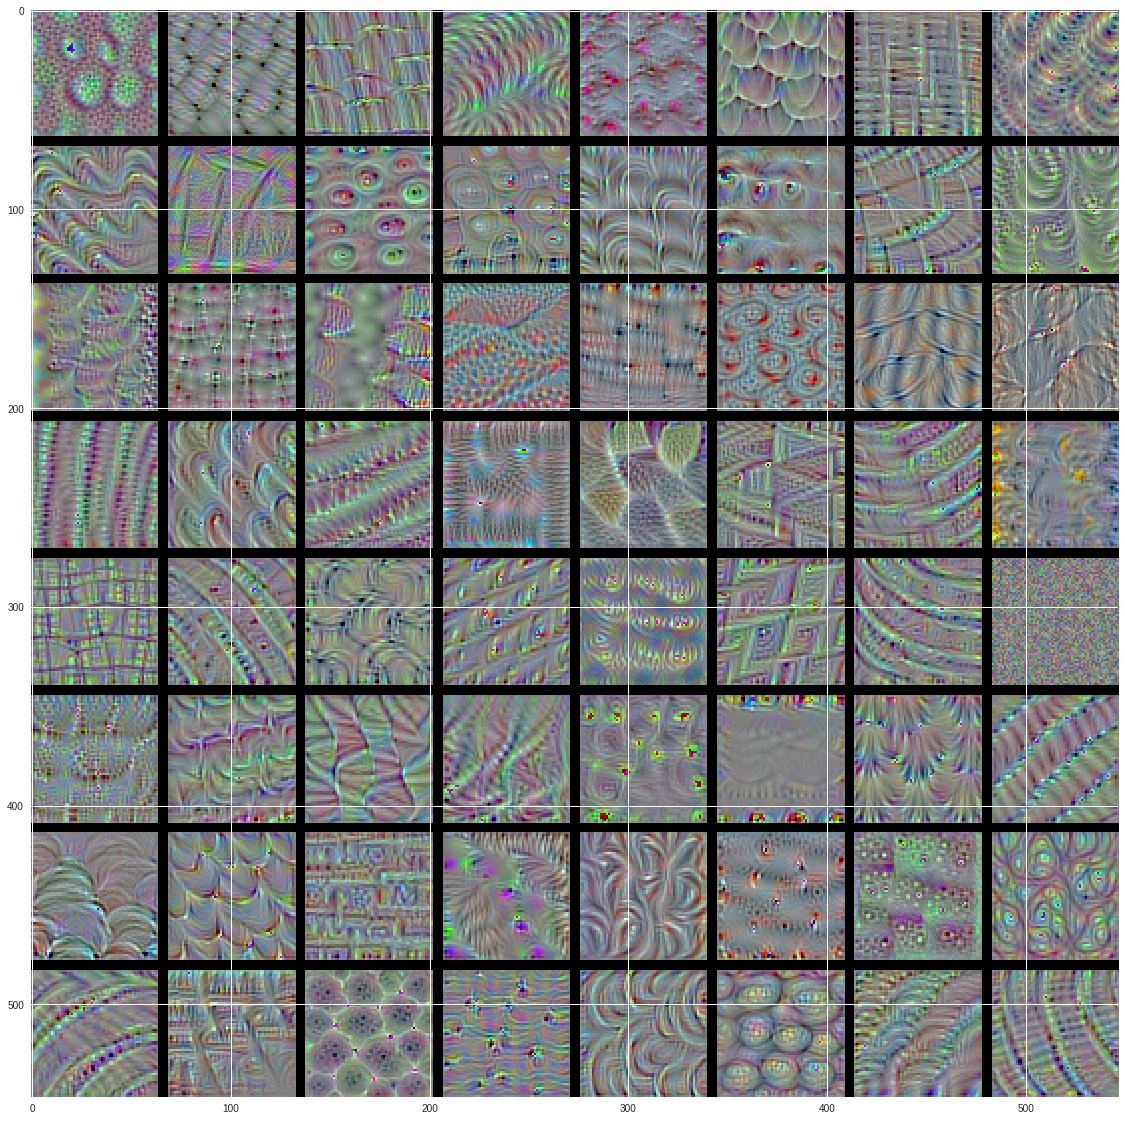

In [33]:
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))      

for i in range(8):                                                         
    for j in range(8):                                                     
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)  

        horizontal_start = i * size + i * margin                           
        horizontal_end = horizontal_start + size                           
        vertical_start = j * size + j * margin                             
        vertical_end = vertical_start + size                               
        results[horizontal_start: horizontal_end,                          
                vertical_start: vertical_end, :] = filter_img              

plt.figure(figsize=(20, 20))                                               
plt.imshow(results)  

# Visualizing heatmaps of class activation

*Helpful in understanding which part of a given image led to it's final classifaction decision. Done using GRAD-CAM.*

In [34]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')       

553467904/553467096 [==============================] - 14s 0us/step


In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'creative_commons_elephants.jpg'     

img = image.load_img(img_path, target_size=(224, 224))                   

x = image.img_to_array(img)                                              

x = np.expand_dims(x, axis=0)                                            

x = preprocess_input(x) 

In [0]:
preds = model.predict(x)

In [37]:
 print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 2us/step
Predicted: [('n02504458', 'African_elephant', 0.8888011), ('n01871265', 'tusker', 0.102234006), ('n02504013', 'Indian_elephant', 0.008635192)]


In [38]:
np.argmax(preds[0])

386

In [0]:
african_elephant_output = model.output[:, 386]                          

last_conv_layer = model.get_layer('block5_conv3')                         

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]   

pooled_grads = K.mean(grads, axis=(0, 1, 2))                              

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])           

pooled_grads_value, conv_layer_output_value = iterate([x])                

for i in range(512):                                                      
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]             

heatmap = np.mean(conv_layer_output_value, axis=-1) 

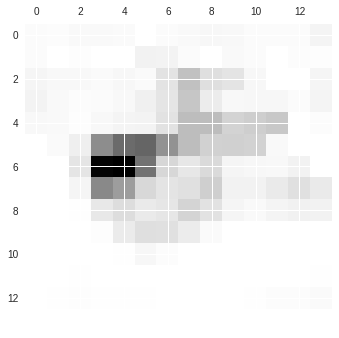

In [41]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [43]:
import cv2

img = cv2.imread(img_path)                                                 

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))                

heatmap = np.uint8(255 * heatmap)                                          

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)                     

superimposed_img = heatmap * 0.4 + img                                     

cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

In [0]:
img = cv2.imread('elephant_cam.jpg')

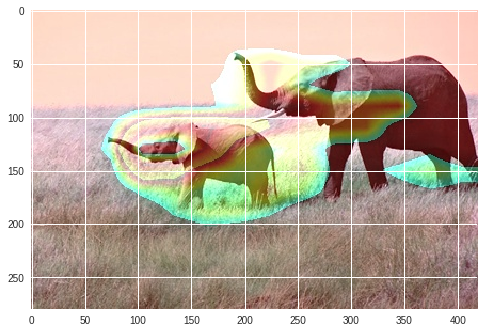

In [50]:
plt.imshow(img)

In [51]:
preds.shape

(1, 1000)